# 导入需要的所有库

In [1]:
import torch as th
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from collections import namedtuple
import random
from copy import deepcopy
from torch.optim import Adam
import numpy as np
import gym
from gym.spaces import Discrete, Box
# from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

# 定义环境

In [2]:
num_packets = 8000 # 一共生成多少个包 
num_load_balancers = 2 #均衡器的数量
num_servers = 4 #服务器的数量

In [3]:
# 代表包本身
class Packet:
    def __init__(self, ip, time_received, processing_time):
        self.ip = ip
        self.time_received = time_received # 每个包只保留被服务器接收的时间
        self.processing_time = processing_time # 每个包的处理时间
        self.waiting = False
    
    def __repr__(self):
        return " @time: " + str(round(self.time_received,3))

# 代表均衡器
class LoadBalancer:
    def __init__(self, ip):
        self.ip = ip
    
    def distribute(self, server, packet):
        return server.add_packet(packet)
    
    def __repr__(self):
        return "Load Balancer: " + str(self.ip)

# 代表服务器，假设服务器用的是FCFS，并且是non-preemptive
class Server:
    def __init__(self, ip, capacity):
        self.ip = ip
        self.capacity = capacity # 服务器队列的最大限制，最大吞入量
        self.queue = [] # 服务器的请求队列
        self.time_pointer = 0 # 记录相当于服务器而言的时间刻度，服务器只能处理这个时刻之后的包
        self.processed_number = 0 # 记录当前服务器已经处理的包的数量
        self.waiting=0
    
    def reset(self):
        self.queue.clear() #清空请求队列
        self.time_pointer = 0
        self.processed_number = 0
        self.waiting = 0
        
    def add_packet(self, packet):
        if len(self.queue) <= self.capacity: # 如果没有超过最大吞入量，则可以继续加
            packet.waiting = False
            self.queue.append(packet)
            # self.queue.sort(key=lambda x: x.time_received, reverse=False)
            return True
        else:
            packet.waiting = True
            self.queue.append(packet)
            return False
                
    # 还得改
    def process(self, current_time): # 处理当前时刻之前的所有包
        if current_time < self.time_pointer or len(self.queue) == 0:
            return
        
        while(len(self.queue) > 0 and self.queue[0].time_received + self.queue[0].processing_time <= current_time ):
            self.processed_number += 1
            if self.queue[0].time_received + self.queue[0].processing_time >= self.time_pointer:
                self.time_pointer = self.queue[0].time_received + self.queue[0].processing_time
            else:
                self.time_pointer = current_time
            # if self.queue[0].time_received + self.queue[0].processing_time
            if self.queue[0].waiting == True:
                self.waiting += current_time-self.queue[0].time_received
            
            self.queue.pop(0)
            
    def get_processed_number(self):
        return self.processed_number
    
    def __repr__(self):
        return str(self.queue)

In [4]:
class NetworkEnv(gym.Env):
    def __init__(self, num_packets = 0, num_servers=0, num_balancers=0, collaborative=True, server_capacity=None):
        assert num_servers == len(server_capacity)
        
        self.packets = [Packet(ip=i, time_received=random.random(), processing_time=random.gauss(0.004,0.002)) for i in range(num_packets)]
        self.packets.sort(key=lambda x: x.time_received, reverse=False)
        
        self.server_capacity = server_capacity # 记录所有server的最大的吞入量

        self.n = num_balancers # agents的数量，也就是均衡器的数量
        self.shared_reward = collaborative #是否是合作模式
        self.time = 0 # 当前的时刻
        self.agents = [LoadBalancer(i) for i in range(num_balancers)]
        self.servers = [Server(i, self.server_capacity[i]) for i in range(num_servers)]
        self.waiting_packets = []
        self.index = 0
        
    def step(self, action_n):
        info = {}
        
        # self.time += 0.004
        # 这一段时间内所有的packet都拿出来然后按照给对应的balancer
        packet = self.packets[self.index : self.index + self.n]
        packet.sort(key=lambda x: x.time_received, reverse=False)
        for i in range(len(packet)):
            self.agents[i].distribute(self.servers[action_n[i]], packet[i])
            
        self.index += self.n
        self.time += 0.00001

        
        # 把包按照他们的ip平均分配给均衡器，再由均衡器按照他们的action跟配给对应的server
            
        # 让每个server进行process
        for s in self.servers:
            s.process(self.time)
            
        done = self.index >= len(self.packets)
        
        temp = []
        for s in self.servers:
            if len(s.queue) !=0 :
                temp.append(sum([p.processing_time for p in s.queue])/len(s.queue))
            else:
                temp.append(0)
            temp.append(s.time_pointer)
            #temp.append(s.get_processed_number())
        obs = [temp] * self.n
        
        reward = []
        if done:
            reward = [-sum([s.waiting  for s in self.servers])/len(self.servers)] * self.n # 需要加上std吗
            # reward = [len(self.waiting_packets)]* self.n
        else:
            reward = [0] * self.n
        
        
        return obs, reward, done, info
    
    def reset(self):
        self.packets = [Packet(ip=i, time_received=random.random(), processing_time=random.gauss(0.004,0.002)) for i in range(num_packets)]
        self.packets.sort(key=lambda x: x.time_received, reverse=False)
        self.time = 0 # 当前的时刻
        self.index = 0
        # self.agents = [LoadBalancer(i) for i in range(self.n)]
        # self.servers = [s.reset() for s in self.servers]
        temp = []
        for s in self.servers:
            s.reset()
            temp.append(0)
            temp.append(s.time_pointer)
            # temp.append(s.get_processed_number())
        obs = [temp] * self.n
        return obs

In [5]:
env = NetworkEnv(num_packets=num_packets, num_servers=num_servers, num_balancers=num_load_balancers, collaborative=True, server_capacity=[50,50,50,50])

In [6]:
episodes = 10
for e in range(1, episodes + 1):
    state = env.reset()
    done = False
    score = 0 # this is the return
    
    while not done:
        action_n = [random.randint(0, num_servers - 1) for i in range(env.n)]
        obs, reward, done, info = env.step(action_n)
        score += reward[0]
    print('Episode: {} Score: {}'.format(e, score))

Episode: 1 Score: -0.12160922303030791
Episode: 2 Score: -0.11726872033495403
Episode: 3 Score: -0.11909249879397152
Episode: 4 Score: -0.1025331989295172
Episode: 5 Score: -0.060995578841705395
Episode: 6 Score: -0.09647238101029967
Episode: 7 Score: -0.08130713743977074
Episode: 8 Score: -0.12819692003005032
Episode: 9 Score: -0.10061535531335283
Episode: 10 Score: -0.08105884786859674


# 将MADDPG加入到当前环境中

In [7]:
Experience = namedtuple('Experience', ('states', 'actions', 'next_states', 'rewards'))
scale_reward = 0.01

In [8]:
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Experience(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [9]:
def sample_gumbel(shape, eps=1e-20):
    U = th.rand(shape)
    '''
    if th.cuda:
         U = U.cuda ()
    '''
    return -th.log(-th.log(U + eps) + eps)


def gumbel_softmax_sample(logits, temperature):
    y = logits + sample_gumbel(logits.size())
    return F.softmax(y / temperature, dim=-1)


def gumbel_softmax(logits, temperature):
   
    y = gumbel_softmax_sample(logits, temperature)

    return y

In [10]:
class Critic(nn.Module):
    def __init__(self, n_agent, dim_observation, dim_action):
        super(Critic, self).__init__()
        self.n_agent = n_agent
        self.dim_observation = dim_observation
        self.dim_action = dim_action
        obs_dim = self.dim_observation * n_agent
        act_dim = self.dim_action * n_agent

        self.FC1 = nn.Linear(obs_dim, 64)
        self.FC2 = nn.Linear(64+act_dim, 64)
        self.FC3 = nn.Linear(64, 64)
        self.FC4 = nn.Linear(64, 1)

    # obs: batch_size * obs_dim
    def forward(self, obs, acts):
        result = F.relu(self.FC1(obs))
        combined = th.cat([result, acts], 1)
        result = F.relu(self.FC2(combined))
        return self.FC4(F.relu(self.FC3(result)))


class Actor(nn.Module):
    def __init__(self, dim_observation, dim_action):
        super(Actor, self).__init__()
        self.FC1 = nn.Linear(dim_observation, 64)
        self.FC2 = nn.Linear(64, 64)
        self.FC3 = nn.Linear(64, dim_action)

    # action output between -2 and 2
    def forward(self, obs):
        result = F.relu(self.FC1(obs))
        result = F.relu(self.FC2(result))
        result = self.FC3(result) # 为什么不用relu呢
        return result

In [11]:
def soft_update(target, source, t):
    for target_param, source_param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_((1 - t) * target_param.data + t * source_param.data)
    
def hard_update(target, source):
    for target_param, source_param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(source_param.data)

class MADDPG:
    def __init__(self, n_agents, dim_obs, dim_act, batch_size, capacity, episodes_before_train):
        self.actors = [Actor(dim_obs, dim_act) for i in range(n_agents)]
        self.critics = [Critic(n_agents, dim_obs, dim_act) for i in range(n_agents)]
        self.actors_target = deepcopy(self.actors)
        self.critics_target = deepcopy(self.critics)
        self.n_agents = n_agents
        self.n_states = dim_obs
        self.n_actions = dim_act
        self.memory = ReplayMemory(capacity)
        self.batch_size = batch_size
        self.use_cuda = th.cuda.is_available()
        self.episodes_before_train = episodes_before_train

        self.GAMMA = 0.95
        self.tau = 0.01

        self.var = [1.0 for i in range(n_agents)]
        self.critic_optimizer = [Adam(x.parameters(), lr=0.001) for x in self.critics]
        self.actor_optimizer = [Adam(x.parameters(), lr=0.0001) for x in self.actors]

        if self.use_cuda:
            for x in self.actors:
                x.cuda()
            for x in self.critics:
                x.cuda()
            for x in self.actors_target:
                x.cuda()
            for x in self.critics_target:
                x.cuda()

        self.steps_done = 0
        self.episode_done = 0

    def update_policy(self):
        # do not train until exploration is enough
        if self.episode_done <= self.episodes_before_train:
            return None, None

        ByteTensor = th.cuda.ByteTensor if self.use_cuda else th.ByteTensor
        FloatTensor = th.cuda.FloatTensor if self.use_cuda else th.FloatTensor

        c_loss = []
        a_loss = []
        for agent in range(self.n_agents):
            transitions = self.memory.sample(self.batch_size)
            batch = Experience(*zip(*transitions))
            non_final_mask = ByteTensor(list(map(lambda s: s is not None, batch.next_states)))
            # state_batch: batch_size x n_agents x dim_obs
            # state_batch = th.stack(batch.states).type(FloatTensor)
            state_batch = th.stack(batch.states)
            # action_batch = th.stack(batch.actions).type(FloatTensor)
            action_batch = th.stack(batch.actions)
            # reward_batch = th.stack(batch.rewards).type(FloatTensor)
            reward_batch = th.stack(batch.rewards)
            # : (batch_size_non_final) x n_agents x dim_obs
            non_final_next_states = th.stack([s for s in batch.next_states if s is not None]).type(FloatTensor)

            # for current agent
            whole_state = state_batch.view(self.batch_size, -1)
            whole_action = action_batch.view(self.batch_size, -1)
            self.critic_optimizer[agent].zero_grad()
            current_Q = self.critics[agent](whole_state, whole_action)

            non_final_next_actions = [self.actors_target[i](non_final_next_states[:, i,:]) for i in range(self.n_agents)]
            non_final_next_actions = th.stack(non_final_next_actions)
            non_final_next_actions = (non_final_next_actions.transpose(0, 1).contiguous())

            target_Q = th.zeros(self.batch_size).type(FloatTensor)

            target_Q[non_final_mask] = self.critics_target[agent](non_final_next_states.view(-1, self.n_agents * self.n_states), 
                                                                  non_final_next_actions.view(-1, self.n_agents * self.n_actions)).squeeze()
            # scale_reward: to scale reward in Q functions

            target_Q = (target_Q.unsqueeze(1) * self.GAMMA) + (reward_batch[:, agent].unsqueeze(1) * scale_reward)

            loss_Q = nn.MSELoss()(current_Q, target_Q.detach())
            loss_Q.backward()
            self.critic_optimizer[agent].step()

            self.actor_optimizer[agent].zero_grad()
            state_i = state_batch[:, agent, :]
            action_i = self.actors[agent](state_i)
            ac = action_batch.clone()
            ac[:, agent, :] = action_i
            whole_action = ac.view(self.batch_size, -1)
            actor_loss = -self.critics[agent](whole_state, whole_action)
            actor_loss = actor_loss.mean()
            actor_loss.backward()
            self.actor_optimizer[agent].step()
            c_loss.append(loss_Q)
            a_loss.append(actor_loss)

        if self.steps_done % 100 == 0 and self.steps_done > 0:
            for i in range(self.n_agents):
                soft_update(self.critics_target[i], self.critics[i], self.tau)
                soft_update(self.actors_target[i], self.actors[i], self.tau)

        return c_loss, a_loss

    def select_action(self, state_batch, temperature=0.2):
        # state_batch: n_agents x state_dim
        actions = th.zeros(self.n_agents, self.n_actions)
        FloatTensor = th.cuda.FloatTensor if self.use_cuda else th.FloatTensor
        for i in range(self.n_agents):
            sb = state_batch[i, :].detach()
            act = self.actors[i](sb.unsqueeze(0)).squeeze()
            act = gumbel_softmax(act, temperature)
            actions[i, :] = act
        self.steps_done += 1

        return actions

In [12]:
reward_record = []

In [13]:
np.random.seed(1234)
th.manual_seed(1234)
n_agents = num_load_balancers
n_states = 8
n_actions = num_servers
capacity = 1000000
batch_size = 256

n_episode = 20000
max_steps = 100
episodes_before_train = 10

win = None
param = None
PATH = 'classifier_modified_env3.pt'
maddpg = MADDPG(n_agents, n_states, n_actions, batch_size, capacity, episodes_before_train)

In [19]:

FloatTensor = th.cuda.FloatTensor if maddpg.use_cuda else th.FloatTensor
for i_episode in range(n_episode):
    obs = env.reset()
    obs = np.stack(obs)
    if isinstance(obs, np.ndarray):
        obs = th.from_numpy(obs).float()
    total_reward = 0.0
    rr = np.zeros((n_agents,))

    done = False
    while not done:
        obs = obs.type(FloatTensor)
        action = maddpg.select_action(obs).data.cpu()
        aa = action.tolist()
        a = []
        for i in aa:
            ssum = sum(i)
            i = [(p / ssum) for p in i]
            a.append(np.random.choice(np.arange(0, 4), p=i))
            #a.append(i.index(max(i)))
            # print(a)
        obs_, reward, done, _ = env.step(a)
        
        reward = th.FloatTensor(reward).type(FloatTensor)
        obs_ = np.stack(obs_)
        obs_ = th.from_numpy(obs_).float()
        next_obs = obs_
        
        # total_reward += reward.sum()
        total_reward += reward[0]
        rr += reward.cpu().numpy()
        maddpg.memory.push(obs.data, action, next_obs, reward)
        # obs = next_obs

        c_loss, a_loss = maddpg.update_policy()

    maddpg.episode_done += 1
    print('Episode: %d, reward = %f' % (i_episode, total_reward))
    reward_record.append(total_reward)
    
    

    if maddpg.episode_done == maddpg.episodes_before_train:
        print('training now begins...')
        print('MADDPG on Network Balancing\n' +
              'scale_reward=%f\n' % scale_reward +
              'agent=%d' % n_agents +
              ' \nlr=0.001, 0.0001, sensor_range=0.3\n' +
              'servers=%d' % (num_servers))
    '''
    if i_episode % 10 == 9:
        th.save({
            'epoch': i_episode,
            'acotr_state_dict': [[maddpg.actors[i].state_dict()] for i in range(len(maddpg.actors))],
            'critic_state_dict': [[maddpg.critics[i].state_dict()] for i in range(len(maddpg.critics))],
            'acotr_target_state_dict': [[maddpg.actors_target[i].state_dict()] for i in range(len(maddpg.actors))],
            'critic_target_state_dict': [[maddpg.critics_target[i].state_dict()] for i in range(len(maddpg.critics))],
            'actor_optimizer_state_dict': [[maddpg.actor_optimizer[i].state_dict()] for i in range(len(maddpg.actor_optimizer))],
            'critic_optimizer_state_dict': [[maddpg.critic_optimizer[i].state_dict()] for i in range(len(maddpg.critic_optimizer))],
            }, PATH)
    '''
# env.close()

Episode: 0, reward = -0.231144
Episode: 1, reward = -0.244805
Episode: 2, reward = -0.314890
Episode: 3, reward = -0.207942
Episode: 4, reward = -0.247682
training now begins...
MADDPG on Network Balancing
scale_reward=0.010000
agent=2 
lr=0.001, 0.0001, sensor_range=0.3
servers=4
Episode: 5, reward = -0.247769


/Users/songrui/.conda/envs/python程序/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:30.)


Episode: 6, reward = -0.293256
Episode: 7, reward = -0.263410
Episode: 8, reward = -0.259326
Episode: 9, reward = -0.309161
Episode: 10, reward = -0.277342
Episode: 11, reward = -0.301206
Episode: 12, reward = -0.263594
Episode: 13, reward = -0.198327
Episode: 14, reward = -0.250589
Episode: 15, reward = -0.297609
Episode: 16, reward = -0.231378
Episode: 17, reward = -0.244339
Episode: 18, reward = -0.207113
Episode: 19, reward = -0.233658
Episode: 20, reward = -0.276434
Episode: 21, reward = -0.276719
Episode: 22, reward = -0.279741
Episode: 23, reward = -0.259497
Episode: 24, reward = -0.260323
Episode: 25, reward = -0.279473
Episode: 26, reward = -0.251386
Episode: 27, reward = -0.276587
Episode: 28, reward = -0.257473
Episode: 29, reward = -0.229828
Episode: 30, reward = -0.268188
Episode: 31, reward = -0.337509
Episode: 32, reward = -0.260544
Episode: 33, reward = -0.265871
Episode: 34, reward = -0.263624
Episode: 35, reward = -0.254854
Episode: 36, reward = -0.235237
Episode: 37,

KeyboardInterrupt: 

In [20]:
th.save({
            'epoch': i_episode,
            'reward': reward_record,
            'acotr_state_dict': [[maddpg.actors[i].state_dict()] for i in range(len(maddpg.actors))],
            'critic_state_dict': [[maddpg.critics[i].state_dict()] for i in range(len(maddpg.critics))],
            'acotr_target_state_dict': [[maddpg.actors_target[i].state_dict()] for i in range(len(maddpg.actors))],
            'critic_target_state_dict': [[maddpg.critics_target[i].state_dict()] for i in range(len(maddpg.critics))],
            'actor_optimizer_state_dict': [[maddpg.actor_optimizer[i].state_dict()] for i in range(len(maddpg.actor_optimizer))],
            'critic_optimizer_state_dict': [[maddpg.critic_optimizer[i].state_dict()] for i in range(len(maddpg.critic_optimizer))],
            }, PATH)

In [17]:
checkpoint = th.load(PATH)
epoch = checkpoint['epoch']
for i in range(len(maddpg.actors)):
  maddpg.actors[i].load_state_dict(checkpoint['acotr_state_dict'][i][0])
  maddpg.critics[i].load_state_dict(checkpoint['critic_state_dict'][i][0])
  maddpg.actors_target[i].load_state_dict(checkpoint['acotr_target_state_dict'][i][0]) 
  maddpg.critics_target[i].load_state_dict(checkpoint['critic_target_state_dict'][i][0]) 
  maddpg.actor_optimizer[i].load_state_dict(checkpoint['actor_optimizer_state_dict'][i][0]) 
  maddpg.critic_optimizer[i].load_state_dict(checkpoint['critic_optimizer_state_dict'][i][0])

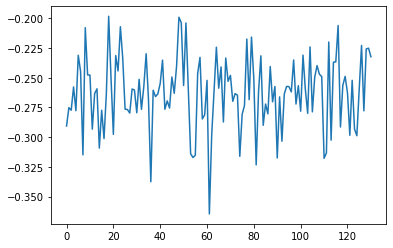

In [21]:
plt.plot(np.arange(len(reward_record)), reward_record)
plt.show()